#Sets up design files for PPI analysis for use in lyman

In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
from moss import glm
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exps = ['sim','ser']
runs = map(str,range(1,4))

In [3]:
#warp group statistical image back into subject space and make mask with OFC
exp = 'ser'
contrast = 'A_v_all'
roi = 'mOFC'
threshold = str(.9)
stat_image = home_dir + '/analysis/group_ser_sim_4mm/' + contrast + '/'+ \
    contrast +'_tfce_corrp_tstat1.nii.gz'
    
for sub in sub_list:
    
    #set paths
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
    mask_path = home_dir + '/data/' + sub
    out_dir = mask_path + '/masks/' + contrast + '/'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    #copy warpfile to make ANTs happy
    warp = mask_path + '/normalization/inverse_warpfield.nii.gz'
    warpfield = mask_path + '/normalization/InverseWarp.nii.gz'
    cmd = ['ln','-s',warp, warpfield]
    os.system(' '.join(cmd))

    #warp to subject space
    out_warp = out_dir + 'anat_space.nii.gz'
    ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
    affine = home_dir + '/data/' + sub + '/normalization/affine.txt'
    anat = home_dir + '/data/' + sub + '/anat/T1_native.nii.gz'
    if not os.path.exists(out_warp):
        cmd_str = ['WarpImageMultiTransform','3',stat_image,out_warp,'-i',affine,warpfield,
                   '-R',anat]
        cmd_str = ' '.join(cmd_str)
        os.system(cmd_str)

    #register to functional space
    transform = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
    mean_func = sub_path + '/preproc/run_1/mean_func.nii.gz'
    out_rigid = out_dir + 'func_space.nii.gz'
    if not os.path.exists(out_rigid):
        cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',out_warp,'--reg',transform,'--o',out_rigid,
                    '--no-save-reg','--inv']
        os.system(' '.join(cmd_line))

    #mask, threshold, and binarize
    out_mask = out_dir + roi + '_mask.nii.gz'
    mask = mask_path + '/masks/' + roi + '_fill_' + exp + '.nii.gz'
    if not os.path.exists(out_mask):
        cmd = ['fslmaths',out_rigid,'-mas',mask,'-thr',threshold,'-bin',out_mask]
        os.system(' '.join(cmd))


#Extract timeseries from the mask

In [80]:
def extract_roi(in_tuple):
    sub,exp,run,mask = in_tuple
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + \
    run + '/'

    #make sure to get coregistered preproc data
    preproc_data = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' \
    + str(run) + '/timeseries_xfm.nii.gz'

    mask_dir = home_dir + 'data/' + sub + '/masks/A_v_all/' 
    out_dir = mask_dir + 'extractions/'
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    mask_file = mask_dir + mask + '_mask.nii.gz'
    out_f = out_dir + ('').join(map(str,in_tuple))+ '.txt'

    if os.path.exists(sub_path):# and not os.path.exists(out_f):
        meants = ImageMeants(in_file = preproc_data, eig = True, order = 1, 
                             mask = mask_file, out_file = out_f)
        meants.run()

In [81]:
exps = ['ser']
rois = ['mOFC']
in_tuples = []
for sub in sub_list:
    for exp in exps:
        for run in runs:
            for mask in rois:
                in_tuples.append((sub,exp,run,mask))

In [82]:
pool = multiprocessing.Pool(processes = 20)
pool.map(extract_roi,in_tuples)
pool.terminate()
pool.join()

#Set up design matrix

In [90]:
def write_design(in_tuple):
    sub,exp = in_tuple

    #hrf params
    hrf = getattr(glm,'GammaDifferenceHRF')
    tr = 1.5
    hrf = hrf(tr = tr)
    
    out_f = home_dir + 'data/' + sub + '/design/ppi_regressors_' + exp + '.csv' #out file

    if True:#not os.path.exists(out_f):
        #load design data for this subjects
        design_dir = home_dir + 'data/' + sub + '/design/'
        design_file = design_dir + exp + '_ppi.csv'
        design_data = pd.read_csv(design_file)

        #load in pre-existing noise regressors
        reg_file = design_dir + 'noise_regressors_' + exp + '.csv'
        regressors = pd.read_csv(reg_file)

        #initialize vars to fill
        convolved_ev = []
        ts = []
        for run in runs:
            sub_file = home_dir + 'analysis/ser_4mm/' + sub + '/preproc/run_' + str(run) + '/smoothed_timeseries.nii.gz'

            if os.path.exists(sub_file):
                ntp = nib.load(sub_file).shape[-1] #get number of time points
                design = design_data[design_data['run']==int(run)]
        
                model = glm.DesignMatrix(design = design, tr = tr, ntp = ntp, hrf_model = hrf, hpf_cutoff = 128)
                convolved_ev.extend(model.design_matrix['state'].values) #get timeseries for regressor of interest

                #load ts data
                mask_dir = home_dir + 'data/' + sub + '/masks/A_v_all/extractions/' 
                fid = (sub,exp,run,mask)
                mask_f = mask_dir + ('').join(map(str,fid))+ '.txt'
                roi_ts = np.loadtxt(mask_f)
                roi_ts = roi_ts - np.mean(roi_ts) #mean center
                ts.extend(roi_ts)

        #update regressors dataframe
        regressors[mask] = ts #add ts to the regressors DF
        regressors['state'] = convolved_ev
        regressors['interaction'] = regressors['state'] * regressors[mask] #interaction regressor

        #write outpt
        regressors.to_csv(out_f, header=True,index = False, columns = ['wm','ventricles',mask,'interaction','run'])
        
        return regressors
regressors  = write_design(('fd_104','ser'))    

In [85]:
exps = ['ser']
in_tuples = []
for sub in sub_list:
    for exp in exps:
        in_tuples.append((sub,exp))

In [87]:
# pool = multiprocessing.Pool(processes = len(in_tuples))
# pool.map(write_design,in_tuples)
# pool.terminate()
# pool.join()

In [7]:
def write_design(in_tuple):
    sub,exp = in_tuple
    mask = 'mOFC'
    #hrf params
    hrf = getattr(glm,'GammaDifferenceHRF')
    tr = 1.5
    hrf = hrf(tr = tr)
    
    out_f = home_dir + 'data/' + sub + '/design/ppi_A_regressors_' + exp + '.csv' #out file

    if True:#not os.path.exists(out_f):
        #load design data for this subjects
        design_dir = home_dir + 'data/' + sub + '/design/'
        design_file = design_dir + exp + '_PE_diff.csv'
        design_data = pd.read_csv(design_file)

        #load in pre-existing noise regressors
        reg_file = design_dir + 'noise_regressors_' + exp + '.csv'
        regressors = pd.read_csv(reg_file)

        #initialize vars to fill
        convolved_ev = []
        ts = []
        for run in runs:
            sub_file = home_dir + 'analysis/ser_4mm/' + sub + '/preproc/run_' + str(run) + '/smoothed_timeseries.nii.gz'

            if os.path.exists(sub_file):
                ntp = nib.load(sub_file).shape[-1] #get number of time points
                design = design_data[design_data['run']==int(run)]
        
                model = glm.DesignMatrix(design = design, tr = tr, ntp = ntp, hrf_model = hrf, hpf_cutoff = 128)
                convolved_ev.extend(model.design_matrix['A'].values) #get timeseries for regressor of interest

                #load ts data
                mask_dir = home_dir + 'data/' + sub + '/masks/A_v_all/extractions/' 
                fid = (sub,exp,run,mask)
                mask_f = mask_dir + ('').join(map(str,fid))+ '.txt'
                roi_ts = np.loadtxt(mask_f)
                roi_ts = roi_ts - np.mean(roi_ts) #mean center
                ts.extend(roi_ts)
                
        ##centre convolved ev (see fsl docs)
        diff = max(convolved_ev)  - (max(convolved_ev) - min(convolved_ev))/2.0
        convolved_ev = convolved_ev - diff
                   
        #update regressors dataframe
        regressors[mask] = ts #add ts to the regressors DF
        regressors['A'] = convolved_ev
        regressors['interaction'] = regressors['A'] * regressors[mask] #interaction regressor

        #orthogonalize noise regressors to speed up computation
        regressors['ventricles'] = vector_rejection(regressors['ventricles'],regressors['wm'])
        
        #write outpt
        regressors.to_csv(out_f, header=True,index = False, columns = ['wm','ventricles',mask,'interaction','run'])
        return regressors
regressors = write_design(('fd_104','ser'))

In [4]:
def vector_rejection(a,b):
    return a - (np.dot(a,b)/np.dot(b,b) * b)

In [147]:
pool = multiprocessing.Pool(processes = len(in_tuples))
pool.map(write_design,in_tuples)
pool.terminate()
pool.join()

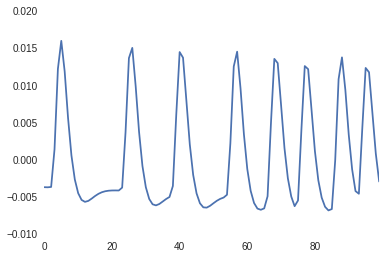

In [119]:
sns.tsplot(regressors['A'][0:100])

0.0123225598058


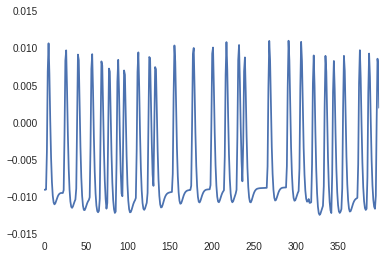

In [134]:
diff = max(regressors['A'])  - (max(regressors['A']) - min(regressors['A']))/2
b = regressors['A'] - diff
# print (max(regressors['A']) - min(regressors['A']))/2
# print np.mean(regressors['A'])
print (max(regressors['A']) - min(regressors['A']))/2
sns.tsplot(b[0:400])

In [19]:
np.dot(regressors['A'].values,regressors['mOFC'].values )

0.4206783057462718